## Study propagation of correlation into a neural network

Our goal is to study how the correlations propagates from an input to the output of the neural network. This study can give us precious information about the behaviour of the accuracy for different sizes.

We want to consider each hidden output as a updated state $ z_{i,0} \rightarrow z_{i,t} $ where $t$ is the t-th block in the neural network.

We use a 2 channel U-net, for this reason each hidden state has two degrees of freedom $z^{\alpha}_{i,t}$ where $\alpha=\{0,1\}$.

In this case we study the evolution of $\langle z^{\alpha}_{l/2,t} z^{\beta}_{l/2+r,t} \rangle= C_{\alpha,\beta}(r,t)$ 

#### Imports

In [2]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import dataloader, nuv_representability_check,mean_field_functional_1nn
from src.training.utils_analysis import test_models_unet
from scipy import stats


#### Data

In [3]:
l=32

model=torch.load('model_rep/2nn_ising/h_5.44_15k_tester_neural_network_[2, 2, 2, 2, 2, 2, 2, 2]_hc_5_ks_1_ps_8_nconv_0_nblock',map_location='cpu')
model.eval()

#we study the training dataset because no overfitting occured and we need at least 1000 samples
data=np.load(f'data/dataset_2nn/test_unet_periodic_2nn_{l}_l_5.44_h_1000_n.npz')
z_numpy=data['density']
f_numpy=data['density_F']
h=data['potential']
z=torch.tensor(z_numpy).double()
h=torch.tensor(h).double()


#### Covariance a the starting point

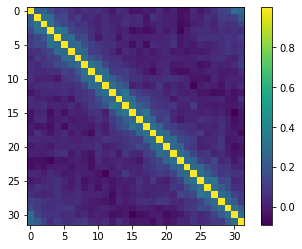

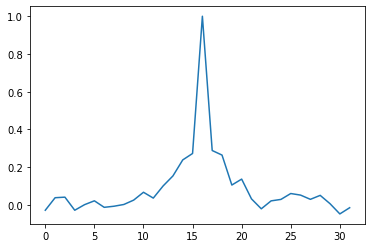

In [4]:
dz=z-z.mean(0)[None,:]
std=dz.std(0)
cov=torch.mean(dz[:,None,:]*dz[:,:,None],dim=0)/(std[None,:]*std[:,None])

plt.imshow(cov.detach().numpy())
plt.colorbar()
plt.show()

plt.plot(cov[int(l/2)].detach().numpy())
plt.show()

Comparison with the external field (should be a delta)

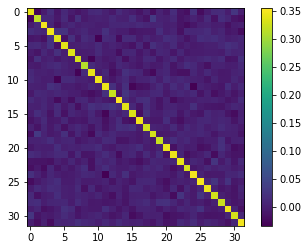

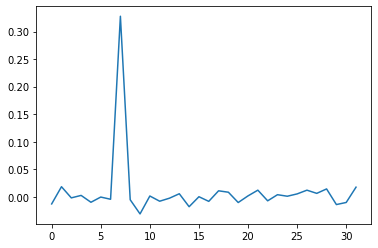

In [5]:
dh=h-h.mean(0)[None,:]
mean_h=h.mean()
cov=torch.mean(dh[:,None,:]*dh[:,:,None],dim=0)/mean_h**2

plt.imshow(cov.detach().numpy())
plt.colorbar()
plt.show()

plt.plot(cov[7].detach().numpy())
plt.show()

#### Evolution of the Covariance

In [68]:
x = torch.unsqueeze(z, dim=1)
outputs = []
for i,block in enumerate(model.conv_downsample):
    x = block(x)
    outputs.append(x)
    if i==0:
        outputs_in=x.unsqueeze(0).detach().numpy()
    else:
        outputs_in=np.append(x.unsqueeze(0).detach().numpy(),outputs_in,axis=0)


for i, block in enumerate(model.conv_upsample):
    if i == 0:
        x = block(x)
        outputs_out=x.unsqueeze(0).detach().numpy()
    else:
        x = x + outputs[model.n_conv_layers - 1 - i]
        x = block(x)
        if i<=len(model.conv_upsample)-2:
            outputs_out=np.append(x.unsqueeze(0).detach().numpy(),outputs_out,axis=0)
        if i==len(model.conv_upsample)-1:
            last_output=x.detach().numpy()
        
f_dens = torch.squeeze(x)


In [69]:
print(outputs_in.shape)
print(outputs_out.shape)

(8, 1000, 2, 32)
(7, 1000, 2, 32)


Compute the covariance at different times

In [67]:
outputs=np.append(outputs_out,outputs_in,axis=0)
mean_w=outputs.mean(axis=(1,-1))
dw=outputs-outputs.mean(axis=1)[:,None,:,:]
cov_w=np.average(dw[:,:,:,None,:]*dw[:,:,:,:,None],axis=1)/mean_w[:,:,None,None]**2




    

(15, 2, 32, 32)


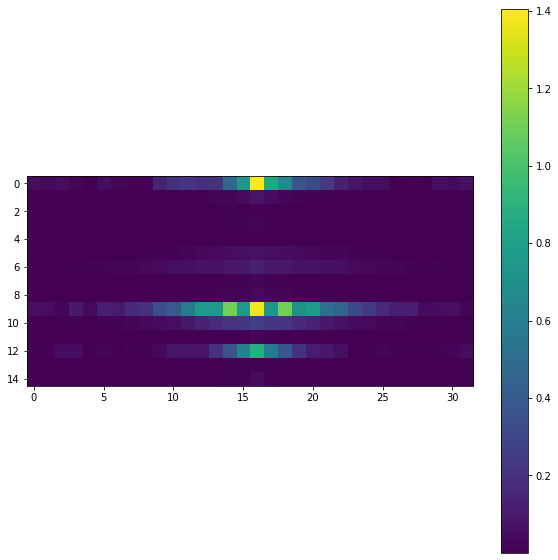

In [9]:
print(cov_w.shape)
plt.figure(figsize=(10,10))
plt.imshow(np.abs(cov_w[:,0,int(l/2),:]))
plt.colorbar()
plt.show()

Covariance in a given time

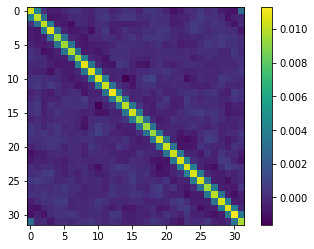

In [10]:
t=4
alpha=0

plt.imshow(cov_w[t,alpha])
plt.colorbar()
plt.show()

#### Covariance of the f density

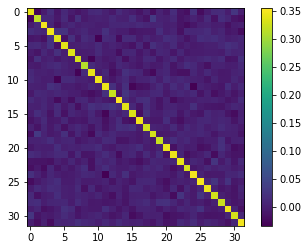

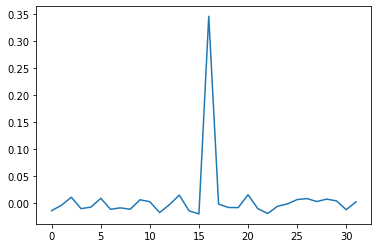

In [11]:
df=f_dens-f_dens.mean(0)[None,:]
mean_f=f_dens.mean()
cov_f=torch.mean(df[:,None,:]*df[:,:,None],dim=0)/mean_f**2

plt.imshow(cov.detach().numpy())
plt.colorbar()
plt.show()

plt.plot(cov[int(l/2)].detach().numpy())
plt.show()

#### Time-correlations

In [12]:
alpha=1
x_0=np.append(z.detach().numpy().reshape(1,z.shape[0],z.shape[1]),outputs[:,:,0,:],axis=0)
#x_0=np.append(x_0,f_dens.detach().numpy().reshape(1,f_dens.shape[0],f_dens.shape[1]),axis=0)
#x_0=np.append(x_0,last_output.reshape(1,z.shape[0],z.shape[-1]),axis=0)
#x_0=outputs

x_1=np.append(z.detach().numpy().reshape(1,z.shape[0],z.shape[1]),outputs[:,:,1,:],axis=0)
#x_1=np.append(x_0,f_dens.detach().numpy().reshape(1,f_dens.shape[0],f_dens.shape[1]),axis=0)
#x_1=np.append(x_1,last_output.reshape(1,z.shape[0],z.shape[-1]),axis=0)
#x_1=outputs


print(x_0.shape)
mean_x=np.average(x_0)
dx0=x_0-np.average(x_0,axis=1)[:,None,:]
mean_x=np.average(x_1)
dx1=x_1-np.average(x_1,axis=1)[:,None,:]


def covtt(dx0,dx1):
    return np.average(dx0[:,None,:,None,:]*dx1[None,:,:,:,None],axis=2)/(np.std(dx0,axis=1)[:,None,None,:]*np.std(dx1,axis=1)[None,:,:,None])



(16, 1000, 32)


#### Analysis of the information propagation

(16, 16, 32, 32)


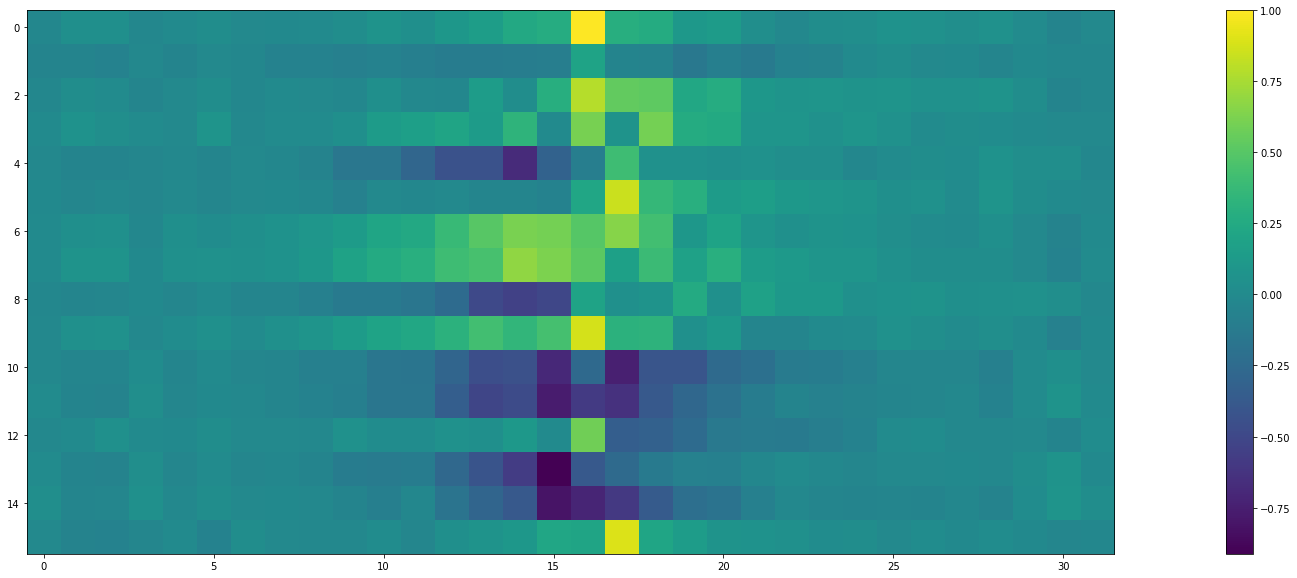

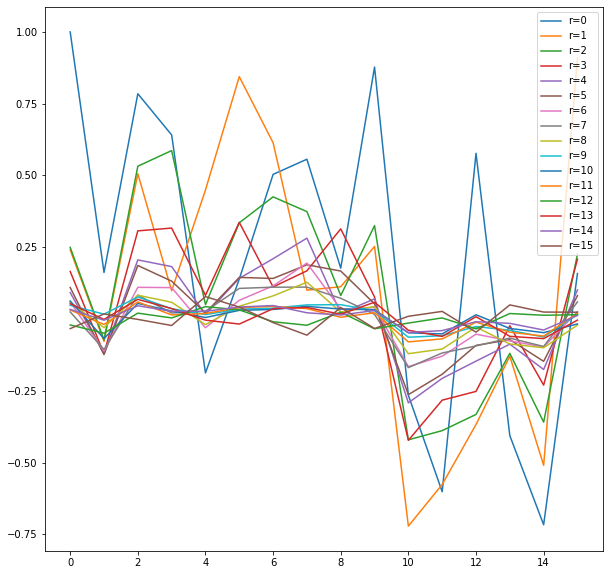

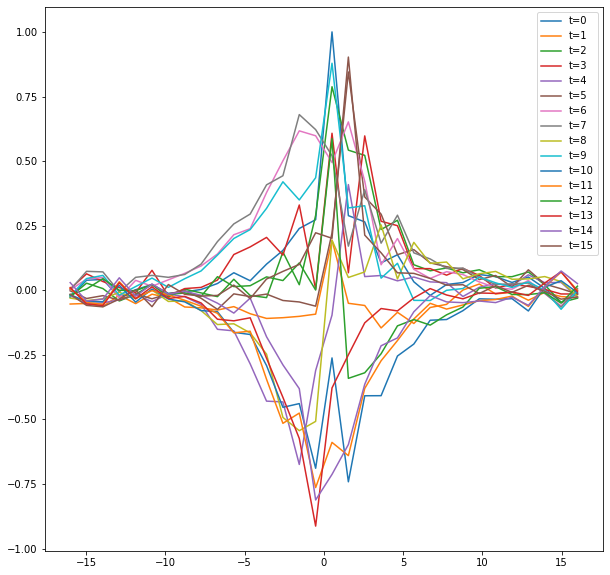

In [14]:
cov=covtt(dx0,dx0)
print(cov.shape)
#time propagation of correlation in l/2
plt.figure(figsize=(40,10))
plt.imshow(cov[0,:,int(l/2),:])
plt.colorbar()
plt.show()

plt.figure(figsize=(10,10))
for i in range(int(l/2)):
    plt.plot(cov[0,:,0,i],label=f'r={i}')
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
space=np.linspace(-l/2,l/2,l)
for i in range(16):
    plt.plot(space,cov[0,i,int(l/2),:],label=f't={i}')
plt.legend()
plt.show()



#### Correlation and causation of the input-output

Data

In [14]:

ls=[16,24,32,64,128]
zs={}
fs={}
fs_ml={}
for l in ls:
    data=np.load(f'data/dataset_2nn/test_unet_periodic_2nn_{l}_l_8.4_h_100_n.npz')
    zs[l]=data['density']
    fs[l]=data['density_F']
    model=torch.load('model_rep/2nn_ising/h_8.4_15k_unet_periodic_augmentation_[40, 40, 40, 40]_hc_5_ks_1_ps_4_nconv_0_nblock',map_location='cpu')
    fs_ml[l]=model(torch.tensor(zs[l]).double()).detach().numpy()

Results

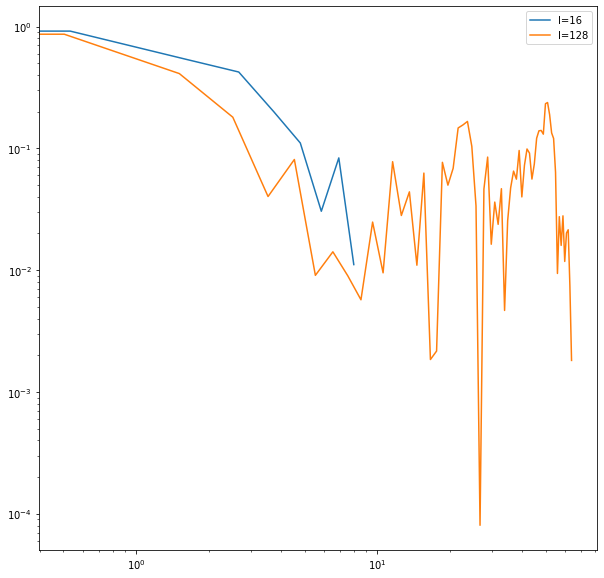

In [15]:
covs={}
gs={}
for l in ls:
    
    x=np.append(zs[l].reshape(zs[l].shape[0],1,zs[l].shape[-1]),fs[l].reshape(zs[l].shape[0],1,zs[l].shape[-1]),axis=1)
    dx=x-np.average(x,axis=0)[None,:,:]
    mean=np.average(x)
    cov=np.average(dx[:,None,:,None,:]*dx[:,:,None,:,None],axis=0)/(np.std(dx,axis=0)[None,:,None,:]*np.std(dx,axis=0)[:,None,:,None])
    covs[l]=cov


    c1=0
    c2=1

    idx=np.arange(l)
    jdx=np.arange(l)
    g=np.zeros((l,l))
    for i in range(l):
        g[:,i]=cov[c1,c2,idx,(idx+i)%l]
    gs[l]=np.average(g,axis=0)

plt.figure(figsize=(10,10))
for l in [16,128]:
    space=np.linspace(-l/2,l/2,l)
    # plt.imshow(cov[c1,c2])
    # plt.colorbar()
    # plt.show()

    plt.plot(space,np.abs(covs[l][c1,c2,int(l/2),:]),label=f'l={l}')
plt.legend()
plt.loglog()
plt.show()

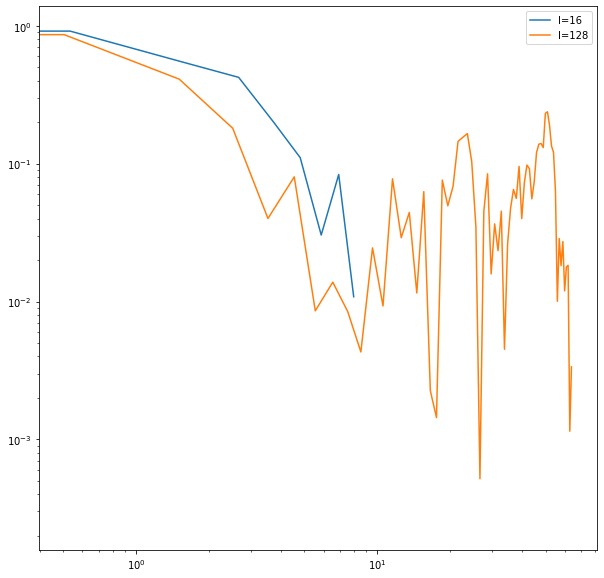

In [16]:
covs_ml={}
gs_ml={}
for l in ls:
    
    x=np.append(zs[l].reshape(zs[l].shape[0],1,zs[l].shape[-1]),fs_ml[l].reshape(zs[l].shape[0],1,zs[l].shape[-1]),axis=1)
    dx=x-np.average(x,axis=0)[None,:,:]
    mean=np.average(x)
    cov=np.average(dx[:,None,:,None,:]*dx[:,:,None,:,None],axis=0)/(np.std(dx,axis=0)[None,:,None,:]*np.std(dx,axis=0)[:,None,:,None])
    covs_ml[l]=cov


    c1=0
    c2=1

    idx=np.arange(l)
    jdx=np.arange(l)
    g=np.zeros((l,l))
    for i in range(l):
        g[:,i]=cov[c1,c2,idx,(idx+i)%l]
    gs_ml[l]=np.average(g,axis=0)

plt.figure(figsize=(10,10))
for l in [16,128]:
    space=np.linspace(-l/2,l/2,l)
    # plt.imshow(cov[c1,c2])
    # plt.colorbar()
    # plt.show()

    plt.plot(space,np.abs(covs_ml[l][c1,c2,int(l/2),:]),label=f'l={l}')
plt.legend()
plt.loglog()
plt.show()

#### Covariance of the error $\delta f_i$ and the magnetization $z_i$

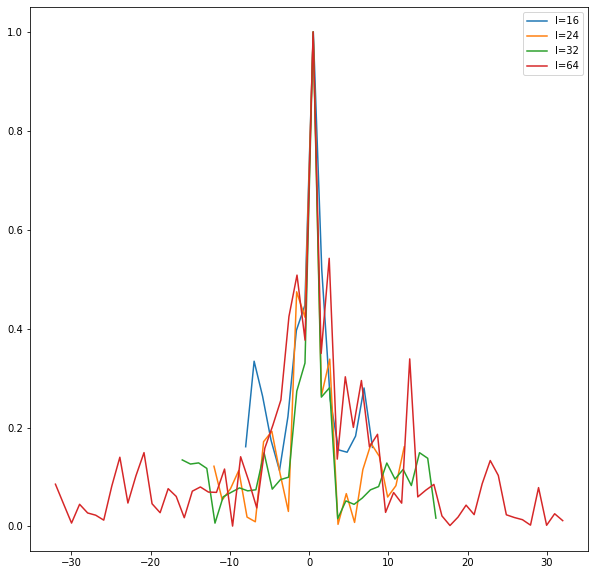

In [25]:
covs_err={}
gs_err={}
for l in ls:
    
    x=np.append(zs[l].reshape(zs[l].shape[0],1,zs[l].shape[-1]),np.abs(fs_ml[l].reshape(zs[l].shape[0],1,zs[l].shape[-1])-fs[l].reshape(zs[l].shape[0],1,zs[l].shape[-1])),axis=1)
    dx=x-np.average(x,axis=0)[None,:,:]
    mean=np.average(x)
    cov=np.average(dx[:,None,:,None,:]*dx[:,:,None,:,None],axis=0)/(np.std(dx,axis=0)[None,:,None,:]*np.std(dx,axis=0)[:,None,:,None])
    covs_err[l]=cov


    c1=1
    c2=1

    idx=np.arange(l)
    jdx=np.arange(l)
    g=np.zeros((l,l))
    for i in range(l):
        g[:,i]=cov[c1,c2,idx,(idx+i)%l]
    gs_err[l]=np.average(g,axis=0)

plt.figure(figsize=(10,10))
for l in [16,24,32,64]:
    space=np.linspace(-l/2,l/2,l)
    # plt.imshow(cov[c1,c2])
    # plt.colorbar()
    # plt.show()

    plt.plot(space,np.abs(covs_err[l][c1,c2,int(l/2),:]),label=f'l={l}')
plt.legend()
#plt.loglog()
plt.show()

#### Comparison between ML and exact covariances

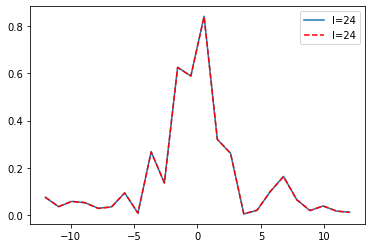

In [18]:
for l in [24]:
    space=np.linspace(-l/2,l/2,l)
    # plt.imshow(cov[c1,c2])
    # plt.colorbar()
    # plt.show()

    plt.plot(space,np.abs(covs_ml[l][c1,c2,int(l/2),:]),label=f'l={l}')
    plt.plot(space,np.abs(covs[l][c1,c2,int(l/2),:]),label=f'l={l}',color='red',linestyle='--')

plt.legend()
#plt.loglog()
plt.show()

(16,)


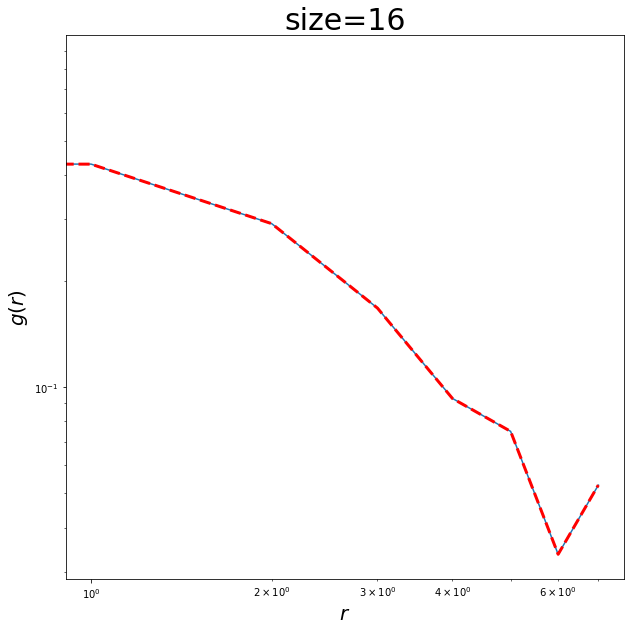

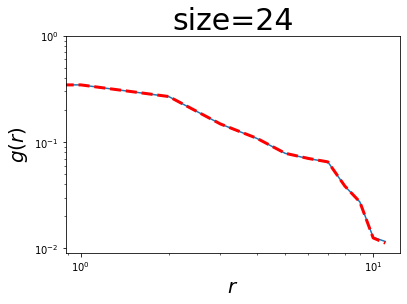

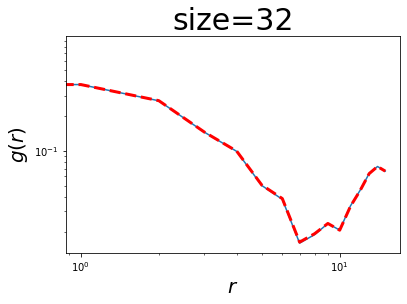

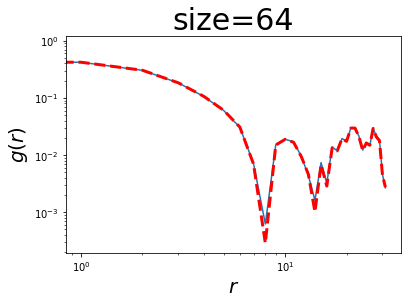

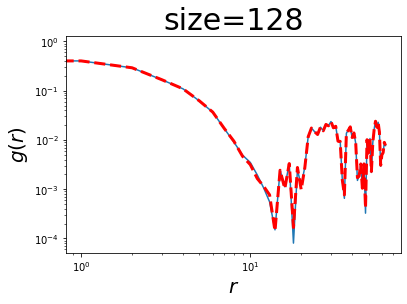

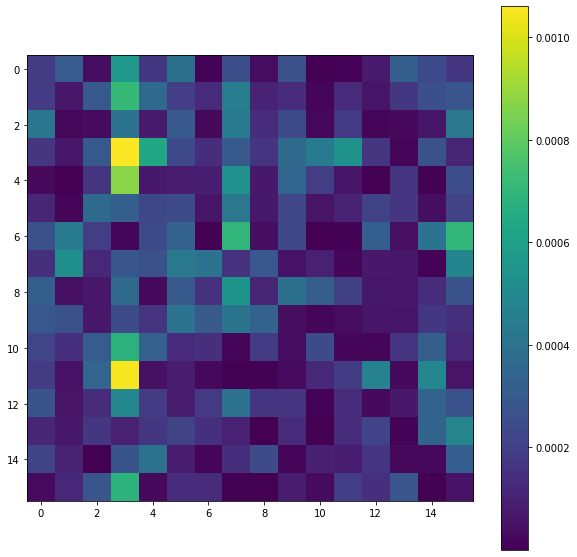

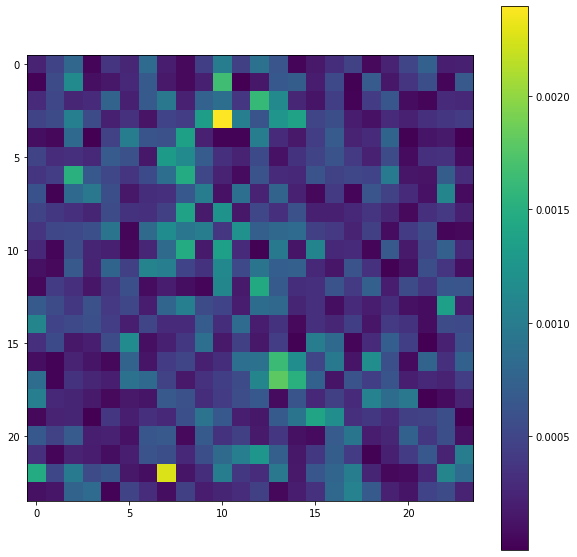

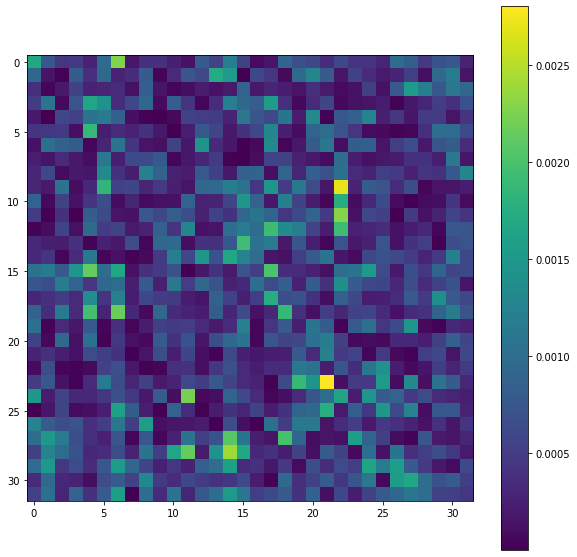

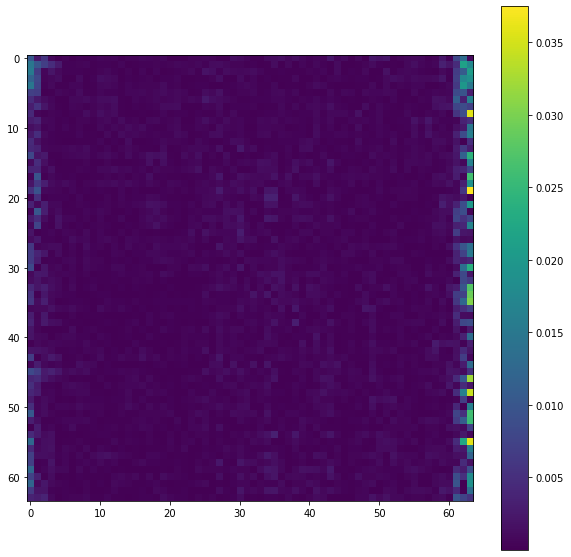

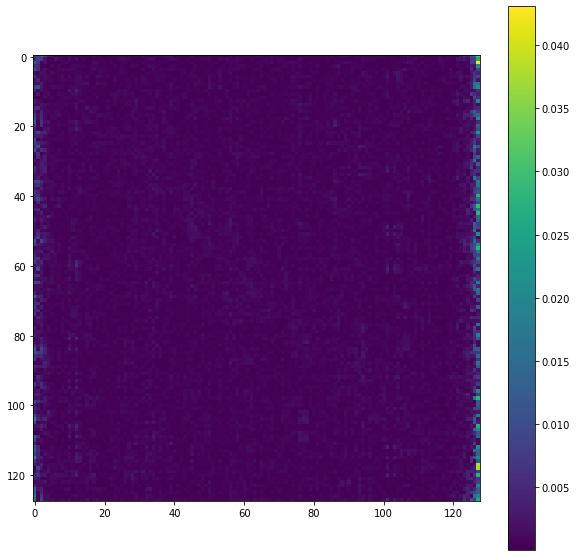

In [123]:
print(gs[16].shape)
plt.figure(figsize=(10,10))
for l in ls:
    plt.plot(np.abs(gs[l][0:int(l/2)]),label='exact')
    plt.plot(np.abs(gs_ml[l][0:int(l/2)]),color='red',linewidth=3,linestyle='--',label='ml')
    plt.loglog()
    plt.xlabel(r'$r$',fontsize=20)
    plt.ylabel(r'$g(r)$',fontsize=20)
    plt.title(f'size={l}',fontsize=30)
    plt.show()
    
for l in ls:
    plt.figure(figsize=(10,10))
    plt.imshow(np.abs(covs[l][c1,c2]-covs_ml[l][c1,c2]))
    plt.colorbar()
    plt.show()
    

#### Comparison of ${f_ml}$ and $f_{dens}$

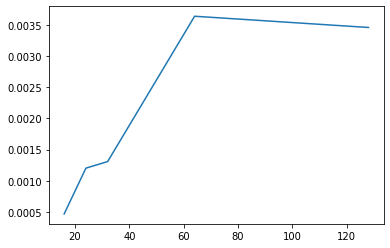

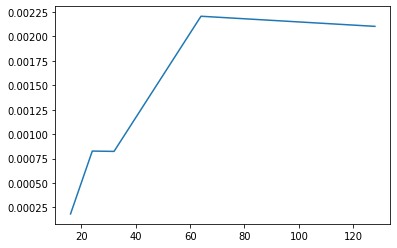

In [9]:
# for i in range(10):
#     plt.plot(fs[16][i])
#     plt.plot(fs_ml[16][i])
#     plt.show()

sample_df={}
err_f=[]
err_f_standard=[]
for l in ls:
    sample_df[l]=np.abs(fs[l]-fs_ml[l])
    err_f.append(np.average(np.average(np.abs(fs[l]-fs_ml[l]),axis=-1)))
    f_sum=np.average(fs[l],axis=-1)
    f_ml_sum=np.average(fs_ml[l],axis=-1)
    err_f_standard.append(np.average(np.abs(f_sum-f_ml_sum)))

plt.plot(ls,err_f)
plt.show()


plt.plot(ls,err_f_standard)
plt.show()

#### Distribution of the error for each size

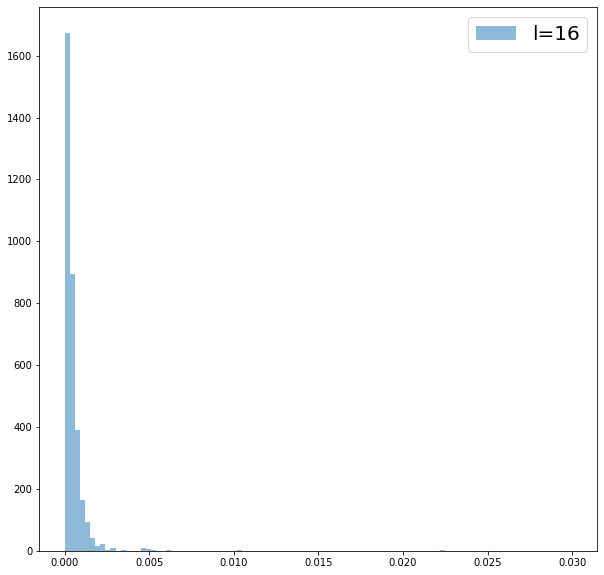

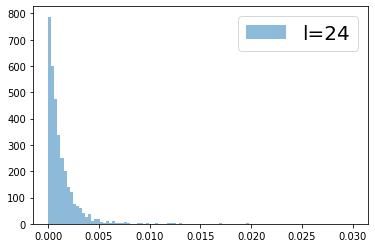

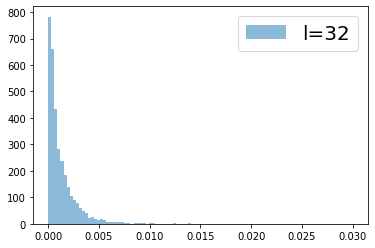

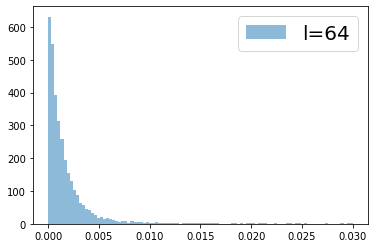

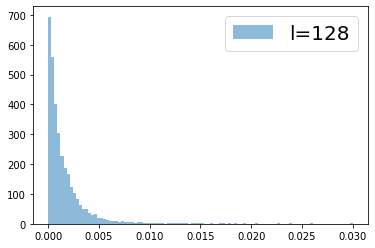

In [15]:
plt.figure(figsize=(10,10))
for l in ls:
    df=sample_df[l].reshape(-1)
    plt.hist(df,bins=100,range=(0,0.03),alpha=0.5,label=f'l={l}',density=True)
    plt.legend(fontsize=20)
    plt.show()    


#### Correlation between output fluctuations and inputs

In [6]:
covs={}
gs={}
for l in ls:
    
    x=np.append(zs[l].reshape(zs[l].shape[0],1,zs[l].shape[-1]),np.abs(fs[l].reshape(zs[l].shape[0],1,zs[l].shape[-1])-fs_ml[l].reshape(zs[l].shape[0],1,zs[l].shape[-1])),axis=1)
    dx=x-np.average(x,axis=0)[None,:,:]
    mean=np.average(x)
    cov=np.average(dx[:,None,:,None,:]*dx[:,:,None,:,None],axis=0)/(np.std(dx,axis=0)[None,:,None,:]*np.std(dx,axis=0)[:,None,:,None])
    covs[l]=cov


    c1=0
    c2=1

    idx=np.arange(l)
    jdx=np.arange(l)
    g=np.zeros((l,l))
    for i in range(l):
        g[:,i]=cov[c1,c2,idx,(idx+i)%l]
    gs[l]=np.average(g,axis=0)


for l in ls:
    plt.figure(figsize=(10,10))
    plt.imshow(covs[l][c1,c2])
    plt.colorbar()
    plt.title(f'l={l}')
    plt.show()
    
for l in ls:
    plt.figure(figsize=(10,10))
    plt.plot(gs[l])
    plt.title(f'l={l}')
    plt.show()
    

NameError: name 'ls' is not defined

## Study in the 1nn case

#### Imports

In [3]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import dataloader, nuv_representability_check,mean_field_functional_1nn
from src.training.utils_analysis import test_models_unet

#### Data

In [28]:

ls=[16,24,32,64,128,256,512]
zs={}
fs={}
fs_ml={}
for l in ls:
    data=np.load(f'data/dataset_1nn/valid_unet_periodic_{l}_l_2.7_h_2000_n.npz')
    zs[l]=data['density']
    fs[l]=data['density_F']
    model=torch.load('model_rep/1nn_ising/h_2.7_15k_tester_neural_network_[2, 2, 2, 2, 2, 2, 2, 2]_hc_5_ks_1_ps_8_nconv_0_nblock',map_location='cpu')
    fs_ml[l]=model(torch.tensor(zs[l]).double()).detach().numpy()

#### Prediction accuracy of the nn

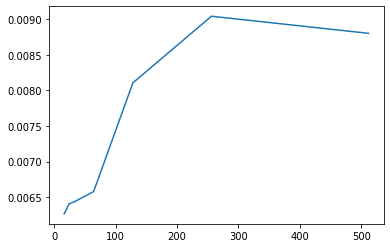

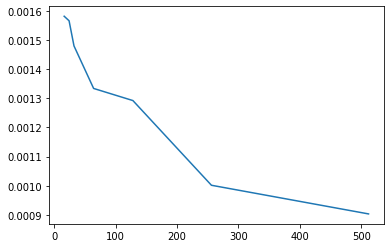

In [29]:
err_f=[]
err_f_standard=[]
for l in ls:
    err_f.append(np.average(np.average(np.abs(fs[l]-fs_ml[l]),axis=-1)/np.average(np.abs(fs[l]),axis=-1),axis=0))
    f_sum=np.average(fs[l],axis=-1)
    f_ml_sum=np.average(fs_ml[l],axis=-1)
    err_f_standard.append(np.average(np.abs(f_sum-f_ml_sum)/np.abs(f_sum)))

plt.plot(ls,err_f)
plt.show()


plt.plot(ls,err_f_standard)
plt.show()

#### Covariance analysis for $F_i$ and $z_i$

In [30]:
covs={}
gs={}
for l in ls:
    
    x=np.append(zs[l].reshape(zs[l].shape[0],1,zs[l].shape[-1]),fs[l].reshape(zs[l].shape[0],1,zs[l].shape[-1]),axis=1)
    dx=x-np.average(x,axis=0)[None,:,:]
    mean=np.average(x)
    cov=np.average(dx[:,None,:,None,:]*dx[:,:,None,:,None],axis=0)/(np.std(dx,axis=0)[None,:,None,:]*np.std(dx,axis=0)[:,None,:,None])
    covs[l]=cov


    c1=0
    c2=1

    idx=np.arange(l)
    jdx=np.arange(l)
    g=np.zeros((l,l))
    for i in range(l):
        g[:,i]=cov[c1,c2,idx,(idx+i)%l]
    gs[l]=np.average(g,axis=0)

plt.figure(figsize=(10,10))
for l in [16,256]:
    space=np.linspace(-l/2,l/2,l)
    # plt.imshow(cov[c1,c2])
    # plt.colorbar()
    # plt.show()

    plt.plot(space,np.abs(covs[l][c1,c2,int(l/2),:]),label=f'l={l}')
plt.legend()
#plt.loglog()
plt.show()

KeyboardInterrupt: 

#### Covariance analysis $F_{i,ML}$ and $z_i$

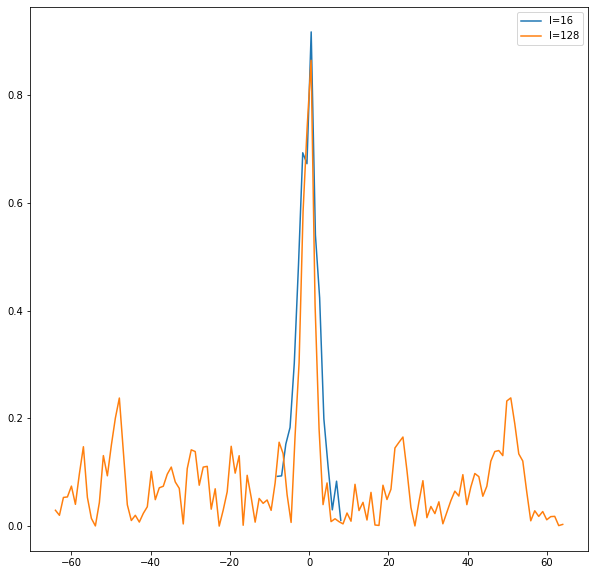

In [16]:
covs_ml={}
gs_ml={}
for l in ls:
    
    x=np.append(zs[l].reshape(zs[l].shape[0],1,zs[l].shape[-1]),fs_ml[l].reshape(zs[l].shape[0],1,zs[l].shape[-1]),axis=1)
    dx=x-np.average(x,axis=0)[None,:,:]
    mean=np.average(x)
    cov=np.average(dx[:,None,:,None,:]*dx[:,:,None,:,None],axis=0)/(np.std(dx,axis=0)[None,:,None,:]*np.std(dx,axis=0)[:,None,:,None])
    covs_ml[l]=cov


    c1=0
    c2=1

    idx=np.arange(l)
    jdx=np.arange(l)
    g=np.zeros((l,l))
    for i in range(l):
        g[:,i]=cov[c1,c2,idx,(idx+i)%l]
    gs_ml[l]=np.average(g,axis=0)

plt.figure(figsize=(10,10))
for l in [16,128]:
    space=np.linspace(-l/2,l/2,l)
    # plt.imshow(cov[c1,c2])
    # plt.colorbar()
    # plt.show()

    plt.plot(space,np.abs(covs_ml[l][c1,c2,int(l/2),:]),label=f'l={l}')
plt.legend()
#plt.loglog()
plt.show()

#### Covariance of $z_i$ and the error $\delta f_i$

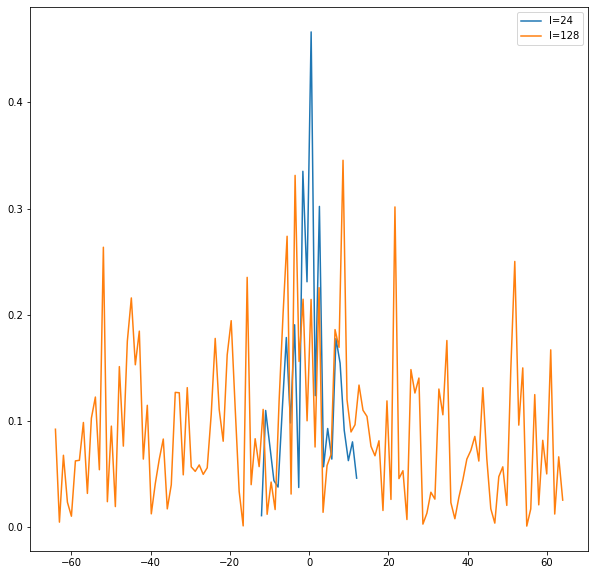

In [26]:
covs_err={}
gs_err={}
for l in ls:
    
    x=np.append(zs[l].reshape(zs[l].shape[0],1,zs[l].shape[-1]),np.abs(fs_ml[l].reshape(zs[l].shape[0],1,zs[l].shape[-1])-fs[l].reshape(zs[l].shape[0],1,zs[l].shape[-1])),axis=1)
    dx=x-np.average(x,axis=0)[None,:,:]
    mean=np.average(x)
    cov=np.average(dx[:,None,:,None,:]*dx[:,:,None,:,None],axis=0)/(np.std(dx,axis=0)[None,:,None,:]*np.std(dx,axis=0)[:,None,:,None])
    covs_err[l]=cov


    c1=0
    c2=1

    idx=np.arange(l)
    jdx=np.arange(l)
    g=np.zeros((l,l))
    for i in range(l):
        g[:,i]=cov[c1,c2,idx,(idx+i)%l]
    gs_err[l]=np.average(g,axis=0)

plt.figure(figsize=(10,10))
for l in [24,128]:
    space=np.linspace(-l/2,l/2,l)
    # plt.imshow(cov[c1,c2])
    # plt.colorbar()
    # plt.show()

    plt.plot(space,np.abs(covs_err[l][c1,c2,int(l/2),:]),label=f'l={l}')
plt.legend()
#plt.loglog()
plt.show()

#### Comparison between covariances

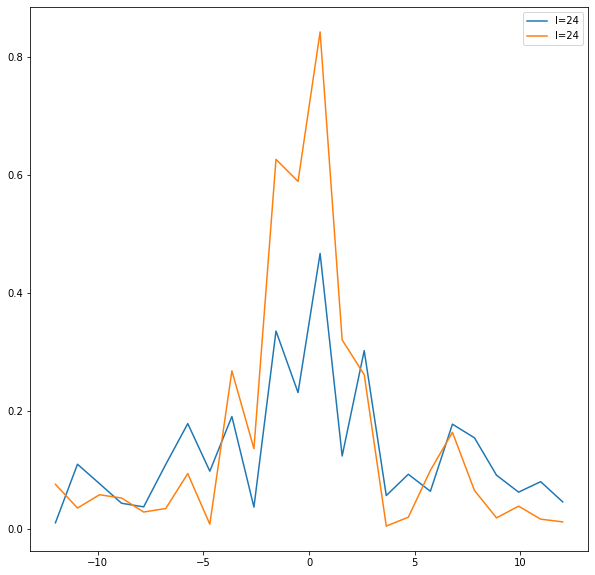

In [25]:
plt.figure(figsize=(10,10))
for l in [24]:
    space=np.linspace(-l/2,l/2,l)
    # plt.imshow(cov[c1,c2])
    # plt.colorbar()
    # plt.show()

    plt.plot(space,np.abs(covs[l][c1,c2,int(l/2),:]),label=f'l={l}')
    plt.plot(space,np.abs(covs_ml[l][c1,c2,int(l/2),:]),label=f'l={l}')
plt.legend()
#plt.loglog()
plt.show()

#### Comparison between ML and exact results

(16,)


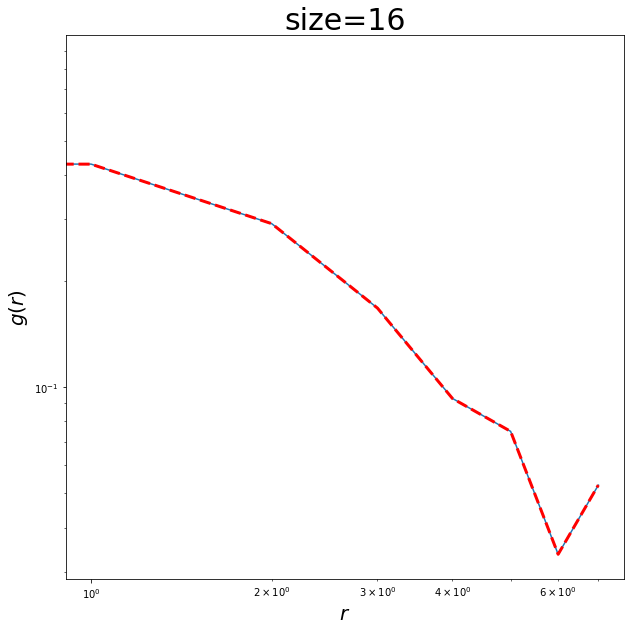

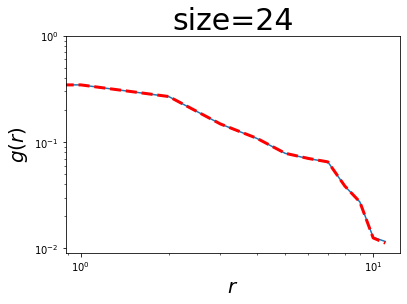

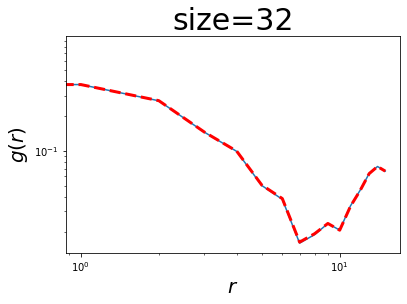

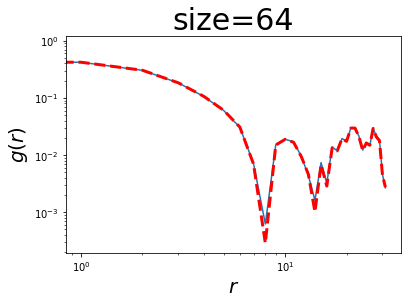

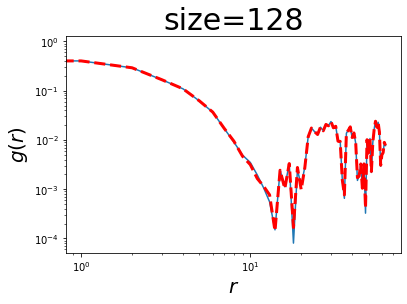

In [17]:
print(gs[16].shape)
plt.figure(figsize=(10,10))
for l in ls:
    plt.plot(np.abs(gs[l][0:int(l/2)]),label='exact')
    plt.plot(np.abs(gs_ml[l][0:int(l/2)]),color='red',linewidth=3,linestyle='--',label='ml')
    plt.loglog()
    #plt.semilogy()
    plt.xlabel(r'$r$',fontsize=20)
    plt.ylabel(r'$g(r)$',fontsize=20)
    plt.title(f'size={l}',fontsize=30)
    plt.show()
    
# for l in ls:
#     plt.figure(figsize=(10,10))
#     plt.imshow(np.abs(covs[l][c1,c2]-covs_ml[l][c1,c2]))
#     plt.colorbar()
#     plt.show()

#### Correlation of the error with the magnetization

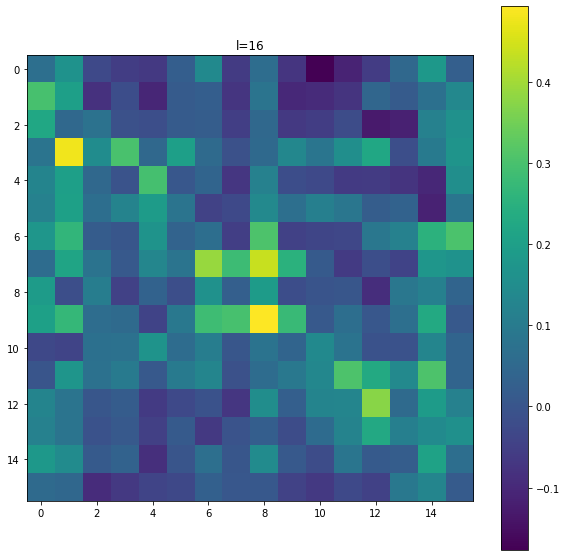

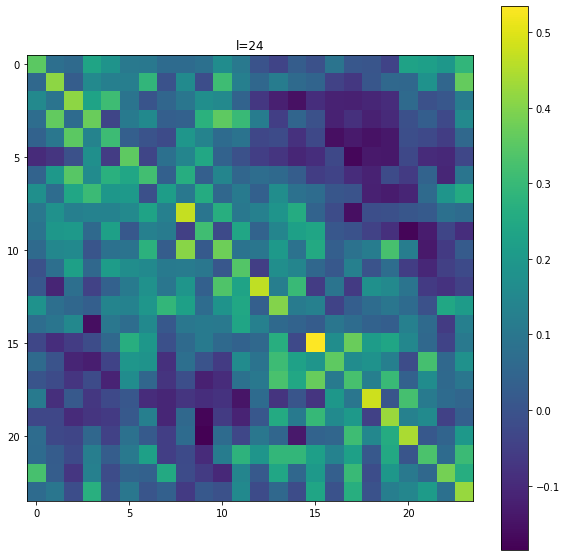

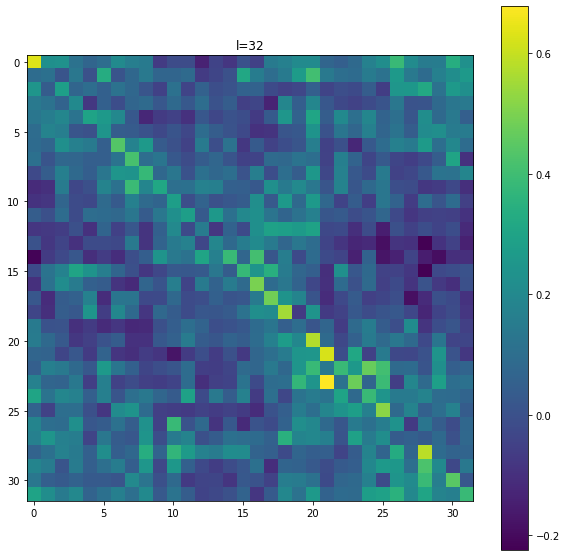

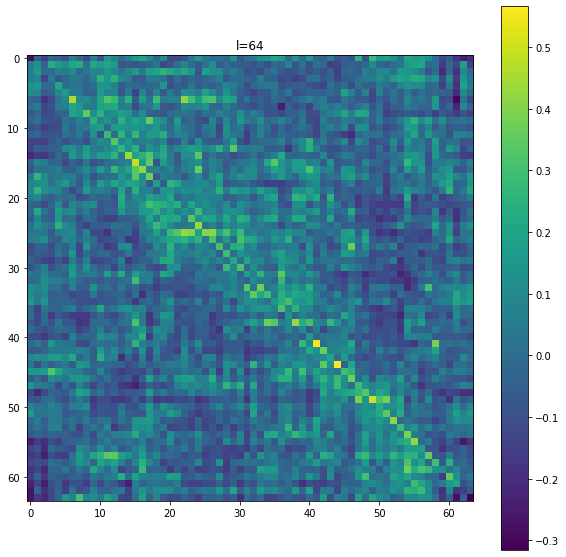

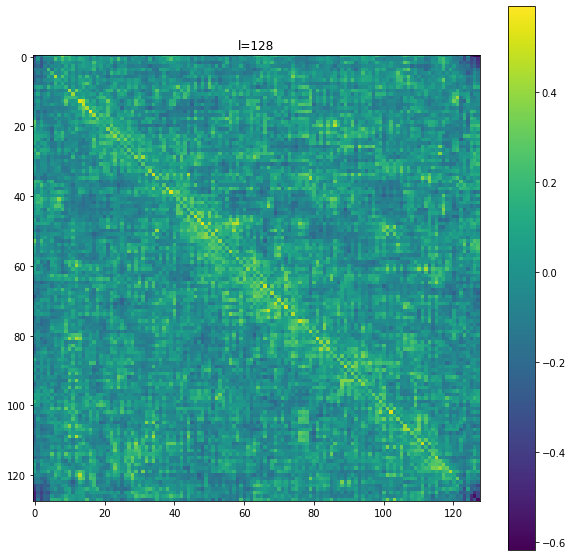

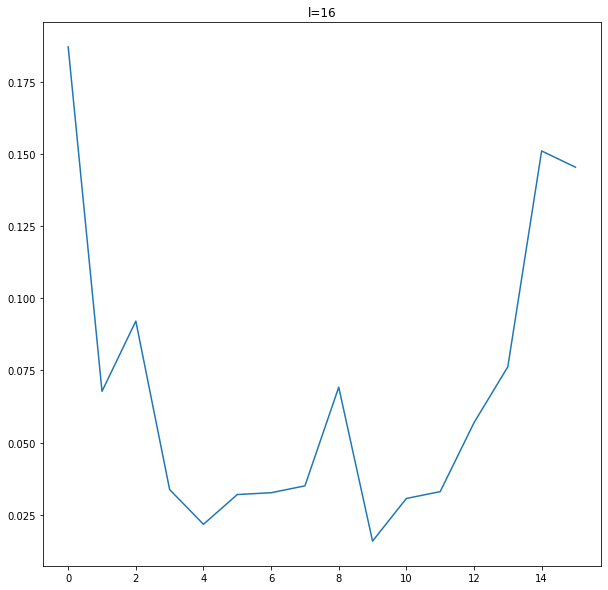

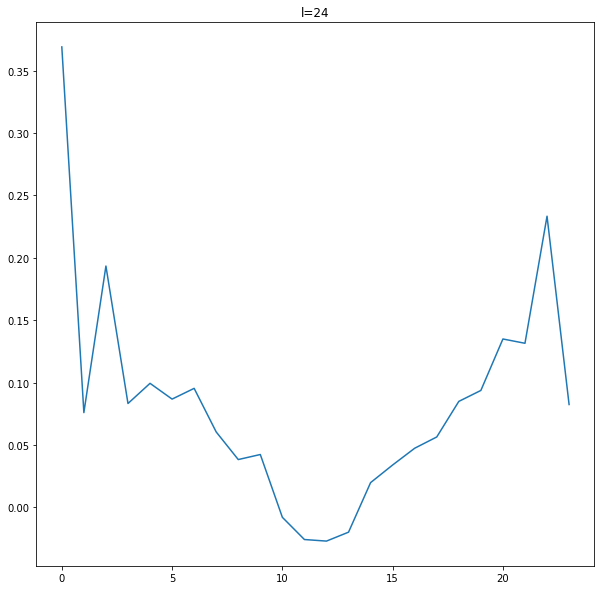

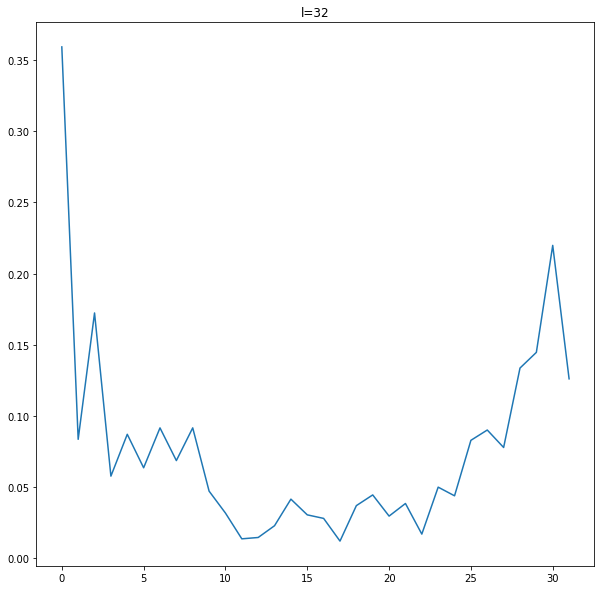

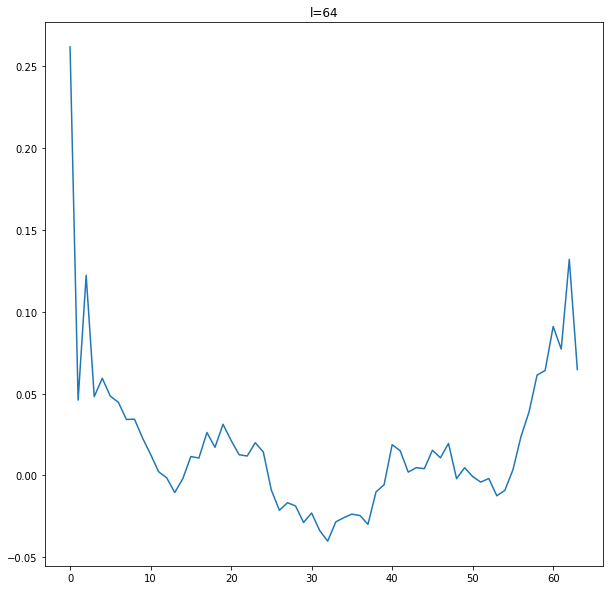

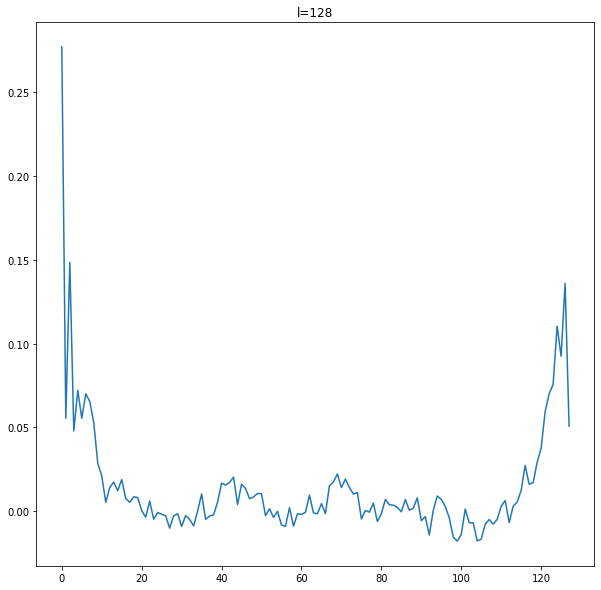

In [18]:
covs={}
gs={}
for l in ls:
    
    x=np.append(zs[l].reshape(zs[l].shape[0],1,zs[l].shape[-1]),np.abs(fs[l].reshape(zs[l].shape[0],1,zs[l].shape[-1])-fs_ml[l].reshape(zs[l].shape[0],1,zs[l].shape[-1])),axis=1)
    dx=x-np.average(x,axis=0)[None,:,:]
    mean=np.average(x)
    cov=np.average(dx[:,None,:,None,:]*dx[:,:,None,:,None],axis=0)/(np.std(dx,axis=0)[None,:,None,:]*np.std(dx,axis=0)[:,None,:,None])
    covs[l]=cov


    c1=0
    c2=1

    idx=np.arange(l)
    jdx=np.arange(l)
    g=np.zeros((l,l))
    for i in range(l):
        g[:,i]=cov[c1,c2,idx,(idx+i)%l]
    gs[l]=np.average(g,axis=0)


for l in ls:
    plt.figure(figsize=(10,10))
    plt.imshow(covs[l][c1,c2])
    plt.colorbar()
    plt.title(f'l={l}')
    plt.show()
    
for l in ls:
    plt.figure(figsize=(10,10))
    plt.plot(gs[l])
    plt.title(f'l={l}')
    plt.show()
    